# NWB Tutorial - Reading NWB Data from DANDI Using PyNWB

## Introduction

In this tutorial, we will learn how to read different kinds of datasets read single neuron spiking data that is in the NWB data standard and stored on the DANDI Archive.

To get a copy of this notebook, go to https://bit.ly/nwb-cosyne-2023

To run this notebook, you will need to first install pynwb, dandi, and fsspec. You may have to restart the notebook kernel to incorporate the changes.

```
pip install -U pynwb dandi fsspec
```

## Set up data streaming from DANDI using fsspec

First, get the S3 path to a particular NWB file on DANDI. We will use data from one session of an experiment by Xioahan Xueat ETH Zurich who performed simultaneous Ca2+ imaging and high-density multielectrode array recording to map monosynaptic connections.

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = "000223"
filepath = "sub-2282/sub-2282_ses-20190914T145458_ecephys+ophys.nwb"
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id).get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

In [2]:
import fsspec
import h5py
from fsspec.implementations.cached import CachingFileSystem

# first, create a virtual filesystem based on the http protocol and use
# caching to save accessed data to RAM.
fs = CachingFileSystem(
    fs=fsspec.filesystem("http"),
    cache_storage="nwb-cache",  # Local folder for the cache
)

# next, create a file object
file_system = fs.open(s3_url, "rb")
file = h5py.File(file_system)

## Using NWBHDF5IO

To read and write data in NWB, we will use the `NWBHDF5IO` class. You can read this as "NWB" "HDF5" "IO". This class reads NWB data that is in the HDF5 storage format, a popular, hierarchical format for storing large-scale scientific data. "IO" stands for Input/Output which means reading/writing data.

Because we are streaming the skeleton of the NWB file from DANDI, this operation can take a couple of minutes, depending on your connection speed.

In [3]:
from pynwb import NWBHDF5IO

io = NWBHDF5IO(file=file, mode='r', load_namespaces=True)  # open the file in read mode 'r'

/Users/rly/mambaforge/envs/caiman/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/rly/mambaforge/envs/caiman/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/rly/mambaforge/envs/caiman/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Call the `NWBHDF5IO.read()` method to read the NWB data into an `NWBFile` object. Print the `NWBFile` object to inspect its contents.

In [4]:
nwb = io.read()
nwb

root pynwb.file.NWBFile at 0x4905354480
Fields:
  acquisition: {
    ElectricalSeries_raw <class 'pynwb.ecephys.ElectricalSeries'>,
    TwoPhotonSeries <class 'pynwb.ophys.TwoPhotonSeries'>
  }
  devices: {
    Mea1k HD-MEA <class 'pynwb.device.Device'>,
    Nikon NiE upright confocal microscope <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    0 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Recording of network-wide extracellular activity with HD-MEA and simultaneous super-resolution calcium imaging to extract single spine responses
  experimenter: ['Xiaohan Xue']
  file_create_date: [datetime.datetime(2022, 2, 16, 22, 19, 57, 630589, tzinfo=tzoffset(None, 3600))]
  identifier: rec8_chip2282
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: ETH Zurich
  lab: Bio Engineering Laboratory (BEL) - Department of Bio Systems Science and Engineering (D-BS

## Access two-photon time series data in NWB

Raw data are stored in the acquisition group of the NWB file. You can access that using `NWBFile.acquisition`.

In [5]:
nwb.acquisition

{'ElectricalSeries_raw': ElectricalSeries_raw pynwb.ecephys.ElectricalSeries at 0x4905355008
 Fields:
   comments: Generated from SpikeInterface::NwbRecordingExtractor
   conversion: 6.29425048828125e-06
   data: <HDF5 dataset "data": shape (5254700, 964), type "<u2">
   description: Raw acquired data
   electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
   offset: 0.0
   rate: 20000.0
   resolution: -1.0
   starting_time: 0.0
   starting_time_unit: seconds
   unit: volts,
 'TwoPhotonSeries': TwoPhotonSeries pynwb.ophys.TwoPhotonSeries at 0x4905356496
 Fields:
   comments: Generalized from RoiInterface
   conversion: 1.0
   data: <HDF5 dataset "data": shape (1800, 512, 512), type "<u2">
   description: no description
   dimension: <HDF5 dataset "dimension": shape (2,), type "<i8">
   imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x4905356976
 Fields:
   conversion: 1.0
   description: no description
   device: Mea1k HD-MEA pynwb.device.Device at 0x490535520

`NWBFile.acquisition` is a dictionary that can contain PyNWB objects representing different types of data, such as electrical time series and two-photon time series. Let's review the `TwoPhotonSeries` object.

In [6]:
twop = nwb.acquisition['TwoPhotonSeries']
print(twop)

TwoPhotonSeries pynwb.ophys.TwoPhotonSeries at 0x4905356496
Fields:
  comments: Generalized from RoiInterface
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1800, 512, 512), type "<u2">
  description: no description
  dimension: <HDF5 dataset "dimension": shape (2,), type "<i8">
  imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x4905356976
Fields:
  conversion: 1.0
  description: no description
  device: Mea1k HD-MEA pynwb.device.Device at 0x4905355200
Fields:
  description: Mea1k HD-MEA device with 26'400 electrodes. 1024 recorded simultaneously.

  excitation_lambda: nan
  imaging_rate: 6.851009572382819
  indicator: unknown
  location: unknown
  optical_channel: (
    channel_0 <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters

  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (1800,), type "<f8">
  timestamps_unit: seconds
  unit: n.a.



## Lazy loading of datasets

Data arrays are read passively from the NWB file. Calling the `data` attribute on a `TimeSeries` such as a `TwoPhotonSeries` does not read the data values, but presents an `h5py` object that can be indexed to read the data. You can use the `[:]` operator to read the entire data array into memory.

This can take some time because we are streaming the data in chunks over the internet.

In [7]:
print(twop.data.shape)
first_image = twop.data[0,:,:]
# all_images = twop.data[:]

(1800, 512, 512)


Time series data in NWB can have multiple dimensions, and the first dimension always represents time.

## Slicing datasets
It is often preferable to read only a portion of the data, e.g., because the full data array is too large to fit into your computer's RAM. To do this, index or slice into the `data` attribute just like if you were indexing or slicing a numpy array.

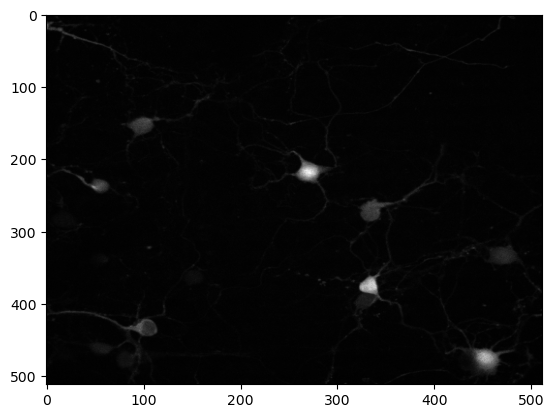

In [8]:
image_index = 2
img = twop.data[image_index,:,:]

import matplotlib.pyplot as plt
plt.imshow(img, aspect='auto', cmap='gray')

Similarly, you can access the `ElectricalSeries` in the `acquisition` group of the NWB file and select a particular region of it to read. For example, the following code reads the first 1000 samples of the first channel of the raw electrical recording by streaming it from DANDI. We can see from the print out of `nwb.acquisition` above that the `ElectricalSeries` object is named `ElectricalSeries_raw`, so we can use that key to index the `nwb.acquisition` dictionary.

In [9]:
eseries = nwb.acquisition['ElectricalSeries_raw']
print(eseries)

ElectricalSeries_raw pynwb.ecephys.ElectricalSeries at 0x4905355008
Fields:
  comments: Generated from SpikeInterface::NwbRecordingExtractor
  conversion: 6.29425048828125e-06
  data: <HDF5 dataset "data": shape (5254700, 964), type "<u2">
  description: Raw acquired data
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  offset: 0.0
  rate: 20000.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts



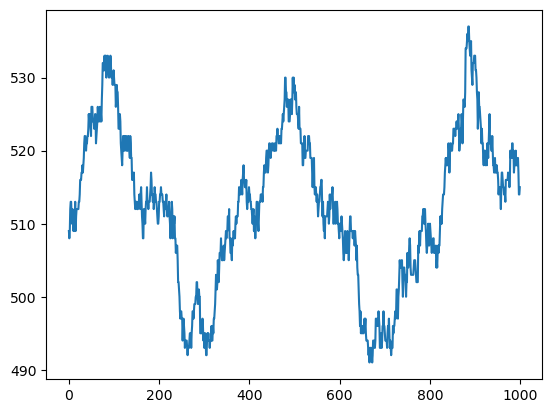

In [10]:
first_channel = eseries.data[:1000, 0]
plt.plot(first_channel)

## Access single unit data in NWB
This dandiset happens to have both optical physiology data and extracellular ephys data. Data and metadata about sorted single units are stored in `NWBFile.units`. `NWBFile.units` is a `Units` object that stores metadata about each single unit in a tabular form, where each row represents a unit and has spike times and additional metadata. Printing the `Units` object shows the column names and basic metadata associated with each unit.

In [11]:
nwb.units

units pynwb.misc.Units at 0x4905357936
Fields:
  colnames: ['spike_times']
  columns: (
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>
  )
  description: Autogenerated by NWBFile
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

We can also view the single unit data as a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [12]:
units_df = nwb.units.to_dataframe()
units_df

,spike_times
id,
0,"[1.42205, 1.5522, 1.5681, 1.60055, 2.2936, 3.0..."
1,"[1.4115, 1.59245, 3.1913, 4.0559, 4.0631, 4.77..."
10,"[0.078, 0.1066, 0.1455, 0.23815, 0.3754, 1.259..."
100,"[0.69175, 1.11955, 1.28495, 2.3467, 2.4271, 2...."
101,"[1.60235, 3.1928, 4.0588, 4.77995, 6.25155, 6...."
...,...
95,"[0.1381, 0.2019, 0.21365, 0.22405, 0.24305, 0...."
96,"[0.1437, 0.2742, 0.3798, 0.39395, 0.417, 0.437..."
97,"[6.2648, 6.71635, 7.85645, 8.0025, 8.7303, 10...."


To access the spike times of the first single unit, index `nwb.units` with the column name 'spike_times' and then the row index, 0. All times in NWB are stored in seconds relative to the session start time.

In [13]:
nwb.units['spike_times'][0]

array([  1.42205,   1.5522 ,   1.5681 ,   1.60055,   2.2936 ,   3.026  ,
         3.1581 ,   3.1663 ,   3.1799 ,   3.21375,   3.2271 ,   4.07325,
         4.77635,   4.78445,   4.7907 ,   4.8031 ,   4.8132 ,   4.8265 ,
         4.8336 ,   6.0037 ,   6.37685,   6.3859 ,   6.4077 ,   6.4314 ,
         7.7946 ,   7.84605,   7.8539 ,   7.8626 ,   7.8741 ,   7.88085,
         7.88995,   8.8879 ,   9.0417 ,   9.21395,   9.4506 ,   9.9738 ,
        10.2523 ,  11.2146 ,  11.23045,  11.2583 ,  11.374  ,  12.9778 ,
        13.15655,  13.1684 ,  13.1763 ,  14.7311 ,  14.7405 ,  14.7521 ,
        14.7654 ,  14.781  ,  14.88495,  16.3238 ,  16.36785,  17.64595,
        17.86615,  18.009  ,  19.41905,  19.42275,  19.5702 ,  20.8996 ,
        20.9435 ,  21.0917 ,  22.39465,  22.52745,  22.55165,  22.6414 ,
        23.25415,  24.721  ,  25.5736 ,  25.57375,  25.582  ,  25.63045,
        25.6366 ,  25.9175 ,  26.7698 ,  26.91355,  27.7853 ,  27.8121 ,
        27.8206 ,  27.8312 ,  27.83785,  27.9047 , 

In [14]:
# for spike_time in nwb.units['spike_times'][0]:
    

## Exploring the NWB file

You can explore the NWB file by printing the `NWBFile` object and accessing its attributes, but it may be useful to explore the data in a less programmatic, more visual way. You can use NWBWidgets, a package containing interactive widgets for visualizing NWB data, or you can use the HDFView tool, which can open any generic HDF5 file, which an NWB file is.

## Conclusion

This is an example of how to get started with understanding and analyzing public NWB datasets. For more datasets, or to publish your own NWB data for free, check out the DANDI Archive.

# Learn more!

## Python tutorials
### See our tutorials for more details about your data type:
* [Extracellular electrophysiology](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ecephys.html#sphx-glr-tutorials-domain-ecephys-py)
* [Calcium imaging](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ophys.html#sphx-glr-tutorials-domain-ophys-py)
* [Intracellular electrophysiology](https://pynwb.readthedocs.io/en/stable/tutorials/domain/icephys.html#sphx-glr-tutorials-domain-icephys-py)

### Check out other tutorials that teach advanced NWB topics:
* [Iterative data write](https://pynwb.readthedocs.io/en/stable/tutorials/general/iterative_write.html#sphx-glr-tutorials-general-iterative-write-py)
* [Extensions](https://pynwb.readthedocs.io/en/stable/tutorials/general/extensions.html#sphx-glr-tutorials-general-extensions-py)
* [Advanced HDF5 I/O](https://pynwb.readthedocs.io/en/stable/tutorials/general/advanced_hdf5_io.html#sphx-glr-tutorials-general-advanced-hdf5-io-py)


## MATLAB tutorials
* [Extracellular electrophysiology](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/ecephys.html)
* [Calcium imaging](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/ophys.html)
* [Intracellular electrophysiology](https://neurodatawithoutborders.github.io/matnwb/tutorials/html/icephys.html)